# MP Expenses Project
by Darren Christie 
Created May 2020

This is a project notebook that looks at MP Expenses.
The notebook compares a single MP (which will probably be your local MP) with the expenses of all MPs.

## The Data
Data has been obtained from the [IPSA website](https://www.theipsa.org.uk/mp-costs/annual-publication/) starting from 2010/2011 csv files were downloaded for individual claims for each reported year. The datasets were downloaded 6/6/2020.
These csv files can be found in the data/raw folder.

The following awk command was used to merge the individual csv files into a combined csv file with a single header.

`awk '(NR == 1) || (FNR > 1)' Individual*.csv > combined_claims.csv`

FNR represents the number of the processed record in a single file. NR represents it globally. Therefore the first line is accepted and the rest are ignored.
I can not take credit for the above awk command. I got it from the StackExchange website (accessed on 14/5/2020) and was an answer provided by a Marek Grac.

The combined csv file can be found in the data/processed folder.

In [23]:
# our standard import for our projects
import warnings
warnings.simplefilter('ignore', FutureWarning)

import matplotlib
import matplotlib.pyplot as plot
matplotlib.rcParams['axes.grid'] = True # show gridlines by default

# tells Jupyter to display all charts inside this notebook, immediately after each call to plot()
%matplotlib inline

import datetime as dt

from pandas import *

In [2]:
# read in our data file of MP Expenses
mpIndExp = read_csv('data/processed/combined_claims.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean up data

In [3]:
# remove apostrophe from column names
mpIndExp.columns = mpIndExp.columns.str.replace("'","")

In [4]:
# correct NaN by replacing with a sensible default value
mpIndExp['Short Description'] = mpIndExp['Short Description'].fillna('')
mpIndExp['Details'] = mpIndExp['Details'].fillna('')
mpIndExp['Journey Type'] = mpIndExp['Journey Type'].fillna('')
mpIndExp['Nights'] = mpIndExp['Nights'].fillna(0.0)
mpIndExp['Mileage'] = mpIndExp['Mileage'].fillna(0.0)
mpIndExp['Reason If Not Paid'] = mpIndExp['Reason If Not Paid'].fillna('')

In [5]:
# drop the Year column
# this column seems redundant considering that we have a date column as well
mpIndExp = mpIndExp.drop('Year', 1)

In [6]:
# correct column types
mpIndExp['Date'] = to_datetime(mpIndExp['Date'])

In [7]:
# remove empty last row
mpIndExp = mpIndExp.dropna(subset=['Date'])

In [8]:
# set the Date column to our index
mpIndExp.index = mpIndExp['Date']
mpIndExp = mpIndExp.sort_index()

## Assumptions about the data
* that the MPs expenses year follows a tax year and runs from 1st April - 31st March.
* that -ve values in the Amount Paid and Claimed columns means that the MP has had to pay money back. This is currently a query I have raised with the IPSA via social media to confirm one way or the other.

## Processing

### Set the MP we are looking at
The MP that we are interested in investigating their expenses.
If you are unsure who your MP is you can find out at [FindYourMP](https://members.parliament.uk/FindYourMP). Enter your post code and it will tell you who you MP is.
**NOTE:** The name of your MP needs to match exactly as it appears in the csv file/dataframe. Otherwise it will not find anything.

In [9]:
LOCALMP = "Stephen Barclay"

### Set some other constants that we will use throughout the notebook

In [10]:
STARTTAXYEAR = 2010
ENDTAXYEAR = 2020

### function definitions used elsewhere in the notebook

In [11]:
# a function to calculate the range
# this works with a groupby function call
# a modified version of code found at http://www.pybloggers.com/2018/12/python-pandas-groupby-tutorial/
def stat_range(df):
    rang = df.max() - df.min()
    
    return rang

### Look at expenses claimed (excluding anything paid back)

In [12]:
# These next line of code basically removes -ve values, which I have assumed means that the MP has repaid money 
# to the IPSA.
allMPsClaims = mpIndExp[mpIndExp['Amount Paid'] > 0]

In [13]:
# create a dataframe to hold our overview stats or top level stats
topLevelStats = DataFrame()

# add a populated Stat column
topLevelStats['Stat'] = ['Sum','Mean','Median','Max','Min','Range','Std']

In [14]:
# add the stats for all the MPs to the top level dataframe
topLevelStats['AllMPs'] = [allMPsClaims['Amount Paid'].sum(),allMPsClaims['Amount Paid'].mean(),allMPsClaims['Amount Paid'].median(),
                          allMPsClaims['Amount Paid'].max(),allMPsClaims['Amount Paid'].min(),allMPsClaims['Amount Paid'].max() - allMPsClaims['Amount Paid'].min(),
                          allMPsClaims['Amount Paid'].std()]

# set index for dataframe to the stat column
topLevelStats.set_index('Stat',inplace = True)

In [15]:
# get the local MPs top level stats
groupedExpenses = allMPsClaims.groupby('MPs Name')
topLevelStats['LocalMP'] = [groupedExpenses.get_group(LOCALMP)['Amount Paid'].aggregate(sum),
                            groupedExpenses.get_group(LOCALMP)['Amount Paid'].aggregate("mean"),
                            groupedExpenses.get_group(LOCALMP)['Amount Paid'].aggregate("median"),
                            groupedExpenses.get_group(LOCALMP)['Amount Paid'].aggregate(max),                          
                            groupedExpenses.get_group(LOCALMP)['Amount Paid'].aggregate(min),
                            groupedExpenses.get_group(LOCALMP)['Amount Paid'].aggregate(max)-groupedExpenses.get_group(LOCALMP)['Amount Paid'].aggregate(min),
                            groupedExpenses.get_group(LOCALMP)['Amount Paid'].aggregate("std")]
topLevelStats = topLevelStats.round(decimals=2)
topLevelStats

,AllMPs,LocalMP
Stat,,
Sum,9.449716e+08,1445649.29
Mean,5.478700e+02,357.92
Median,3.181000e+01,27.00
Max,1.782618e+05,136664.20
Min,1.000000e-02,0.17
Range,1.782618e+05,136664.03
Std,6.955740e+03,5218.26


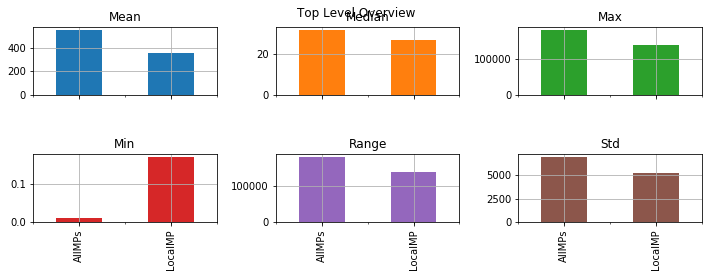

In [16]:
# lets make a chart or two for this top level view
#plot.subplots(3,3,constrained_layout=True)
topLevelStats.transpose().loc[:,'Mean':'Std'].plot.bar(title='Top Level Overview',figsize=(10,5),subplots=True, layout=(3,3),legend=False)
plot.tight_layout()

In [32]:
localMPExpenses = groupedExpenses.get_group(LOCALMP)
localMPSummaryExpenses = localMPExpenses.groupby('Category')['Amount Paid'].agg(['sum','mean', 'median', 'max', 'min',stat_range,'std'])
localMPSummaryExpenses = localMPSummaryExpenses.round(decimals=2) # round to 2 decimal places
localMPSummaryExpenses = localMPSummaryExpenses.fillna(0.0) # replace any NaN with a zero
localMPSummaryExpenses

,sum,mean,median,max,min,stat_range,std
Category,,,,,,,
Accommodation,146634.07,362.06,150.00,2790.00,1.70,2788.30,503.99
Dependant Travel,3051.99,76.30,82.62,94.95,41.31,53.64,20.94
MP Travel,70831.82,38.16,14.50,8680.00,1.17,8678.83,273.99
Miscellaneous Expenses,2910.68,242.56,204.16,540.00,89.40,450.60,117.20
Office Costs,201886.41,263.22,110.16,3960.00,0.17,3959.83,359.39
Office Costs Expenditure,837.60,837.60,837.60,837.60,837.60,0.00,0.00
Staff Travel,12307.91,22.54,9.96,760.50,0.22,760.28,41.00
Staffing,1007188.81,2444.63,4.86,136664.20,1.21,136662.99,16177.12


In [20]:
localMPExpenses.head()

,Date,Claim No.,MPs Name,MPs Constituency,Category,Expense Type,Short Description,Details,Journey Type,From,...,Nights,Mileage,Amount Claimed,Amount Paid,Amount Not Paid,Amount Repaid,Status,Reason If Not Paid,Supply Month,Supply Period
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-09,2010-01-09,27850,Stephen Barclay,North East Cambridgeshire CC,Accommodation,Accommodation Rent,Rent [***] Oct 2010,Rent [***],,NaN,...,0.0,0.0,1450.00,1450.00,0.0,0.0,Paid,,0,0
2010-01-09,2010-01-09,27847,Stephen Barclay,North East Cambridgeshire CC,Miscellaneous Expenses,Contingency,Top-up rent October 2010,Top-up rent before baby born,,NaN,...,0.0,0.0,204.16,204.16,0.0,0.0,Paid,,0,0
2010-01-09,2010-01-09,32683,Stephen Barclay,North East Cambridgeshire CC,MP Travel,Own Car MP,,,London Home to Const Home,NaN,...,0.0,0.0,36.48,36.48,0.0,0.0,Paid,,0,0
2010-01-09,2010-01-09,32683,Stephen Barclay,North East Cambridgeshire CC,MP Travel,Own Car MP,,,Const Office to Westminster,NaN,...,0.0,0.0,39.28,39.28,0.0,0.0,Paid,,0,0
2010-01-09,2010-01-09,32683,Stephen Barclay,North East Cambridgeshire CC,MP Travel,Own Car MP,,,Travel within Constituency,NaN,...,0.0,0.0,3.08,3.08,0.0,0.0,Paid,,0,0


In [33]:
localMPSummaryDetailedExpenses = localMPExpenses.groupby(['Category','Expense Type'])['Amount Paid'].agg(['sum','mean', 'median', 'max', 'min',stat_range,'std'])
localMPSummaryDetailedExpenses = localMPSummaryDetailedExpenses.round(decimals=2) # round to 2 decimal places
localMPSummaryDetailedExpenses = localMPSummaryDetailedExpenses.fillna(0.0) # replace any NaN with a zero
localMPSummaryDetailedExpenses

sum     mean  \
Category      Expense Type                                              
Accommodation Accommodation Rent                    79001.12  1519.25   
              Council Tax                            1816.75   605.58   
              Electricity                             245.34    81.78   
              Gas                                     529.10   132.28   
              Hotel - London                         6650.00   332.50   
...                                                      ...      ...   
Staffing      Professional Services (Staff.)         9613.00  1068.11   
              Public Tr UND Volunteer                  35.10     5.85   
              Staff Training Costs                   1236.00   618.00   
              Training - staff                        438.60   438.60   
              Volunteer - agreed arrangement costs    497.25     5.53   

                                                     median      max     min  \
Category      Expense Type                                                     
Accommodation Accommodation Rent                    1841.67  2790.00  100.00   
              Council Tax                            181.00  1485.17  150.58   
              Electricity                             78.27   120.00   47.07   
              Gas                                    135.00   180.00   79.10   
              Hotel - London                         350.00   525.00  175.00   
...                                                     ...      ...     ...   
Staffing      Professional Services (Staff.)         700.00  3780.00  175.00   
              Public Tr UND Volunteer                  2.40    23.10    2.40   
              Staff Training Costs                   618.00   816.00  420.00   
              Training - staff                       438.60   438.60  438.60   
              Volunteer - agreed arrangement costs     4.86    10.80    4.68   

                                                    stat_range      std  
Category      Expense Type                                               
Accommodation Accommodation Rent                       2690.00   580.98  
              Council Tax                              1334.59   761.90  
              Electricity                                72.93    36.59  
              Gas                                       100.90    55.29  
              Hotel - London                            350.00   149.14  
...                                                        ...      ...  
Staffing      Professional Services (Staff.)           3605.00  1172.79  
              Public Tr UND Volunteer                    20.70     8.45  
              Staff Training Costs                      396.00   280.01  
              Training - staff                            0.00     0.00  
              Volunteer - agreed arrangement costs        6.12     1.88  

[108 rows x 7 columns]

Creating some yearly summary stats for the MP

In [35]:
currTaxYear = STARTTAXYEAR
for counter in range (0,(ENDTAXYEAR - STARTTAXYEAR)):
    tempIndex = str(currTaxYear)+'/'+str(currTaxYear+1)
    tempDF = localMPExpenses.loc[dt.datetime(currTaxYear,4,1):dt.datetime(currTaxYear+1,3,31)]
    yearlyCategorySummary = tempDF.groupby('Category')['Amount Paid'].agg(['sum','mean', 'median', 'max', 'min',stat_range,'std'])
    yearlyDetailSummary = tempDF.groupby(['Category','Expense Type'])['Amount Paid'].agg(['sum','mean', 'median', 'max', 'min',stat_range,'std'])
    print(tempIndex)
    currTaxYear += 1
    
yearlyCategorySummary.head()
yearlyDetailSummary.head()

2010/2011
2011/2012
2012/2013
2013/2014
2014/2015
2015/2016
2016/2017
2017/2018
2018/2019
2019/2020


sum        mean  median     max     min  \
Category      Expense Type                                                     
Accommodation Hotel - London     5775.00  320.833333  350.00  525.00  175.00   
              Hotel London Area   775.00  193.750000  162.50  300.00  150.00   
MP Travel     Hotel - London     1515.00  252.500000  175.00  525.00  175.00   
              Mileage - car       995.40   12.600000   12.60   12.60   12.60   
              Own Vehicle Car     200.16   12.510000   12.51   12.51   12.51   

                                 stat_range         std  
Category      Expense Type                               
Accommodation Hotel - London          350.0  150.061262  
              Hotel London Area       150.0   71.807033  
MP Travel     Hotel - London          350.0  141.200212  
              Mileage - car             0.0    0.000000  
              Own Vehicle Car           0.0    0.000000

This next bit loops round extracting each years stats.
A year runs from 1st May - 30th April which follows a tax year.

In [ ]:
#for counter in range (0,(endYear - startYear)):
#    tempIndex = str(currYear)+'/'+str(currYear+1)
    # get the data for the current tax year
#    tempDF = localMPExpenses.loc[datetime(currYear,5,1):datetime(currYear+1,4,30)]
    # These next two lines of code basically remove -ve values, which I have assumed means that the MP has repaid money 
    # to the IPSA.
#    tempDF1 = tempDF[tempDF['Amount Paid'] >= 0]
#    tempAmountPaid = tempDF1['Amount Paid']
    # collect group data by Category then by Expense Type
#    expensesGroups = tempDF1['Amount Paid'].groupby(tempDF1['Category'])
#    mpTopLevelStatsMean[tempIndex] = expensesGroups.mean()
#    mpTopLevelStatsMedian[tempIndex] = expensesGroups.median()
#    mpTopLevelStatsMax[tempIndex] = expensesGroups.max()
#    mpTopLevelStatsMin[tempIndex] = expensesGroups.min()
#    mpTopLevelStatsRange[tempIndex] = (expensesGroups.max()-expensesGroups.min())
    # add a column for the tax year to the top level
    #mpTopLevelStatsMean[tempIndex] = [topLevelGroups.mean()]
    # collect group data by Category then by Expense Type
    #expensesGroups = tempDF1['Amount Paid'].groupby([tempDF1['Category'],tempDF1['Expense Type']])
    # build up our stats
#    mpYearlyData.append([tempAmountPaid.mean(),tempAmountPaid.median(),tempAmountPaid.sum(),tempAmountPaid.max(),tempAmountPaid.min(),(tempAmountPaid.max() - tempAmountPaid.min())])
#    mpYearlyDataIndex.append(tempIndex)
#    currYear += 1

## To Do List
A list of ideas I have to expand this porject.
- Add in the MP Basic Salary.
    I think taking into account whether an MP has held a position such as being on a select committee or become
    a minister and the extra pay they would get is "too complicated".
    
- Add in the current tax year to date claims
    - compare them to the historic data
    - predict where they might go